In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from keras.callbacks import EarlyStopping

%matplotlib inline

In [7]:
from google.colab import drive
drive.mount('/content/drive')

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [13]:
IMG_WIDTH = 540
IMG_HEIGHT = 420

# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
    
    return img

In [8]:
!nvidia-smi

Wed Sep 14 14:30:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
train_img = sorted(os.listdir('/content/drive/MyDrive/train/train/'))
train_cleaned_img = sorted(os.listdir('/content/drive/MyDrive/train_cleaned/train_cleaned/'))
test_img = sorted(os.listdir('/content/drive/MyDrive/test/'))
# test_invoice_img = sorted(os.listdir('/content/drive/MyDrive/saved_images'))

In [14]:
train = []
train_cleaned = []
test = []

for f in train_img:
    train.append(process_image('/content/drive/MyDrive/train/train/'+ f))

for f in train_cleaned_img:
    train_cleaned.append(process_image('/content/drive/MyDrive/train_cleaned/train_cleaned/' + f))
    


In [28]:
test = []
for f in test_img:
    test.append(process_image('/content/drive/MyDrive/test/' + f))

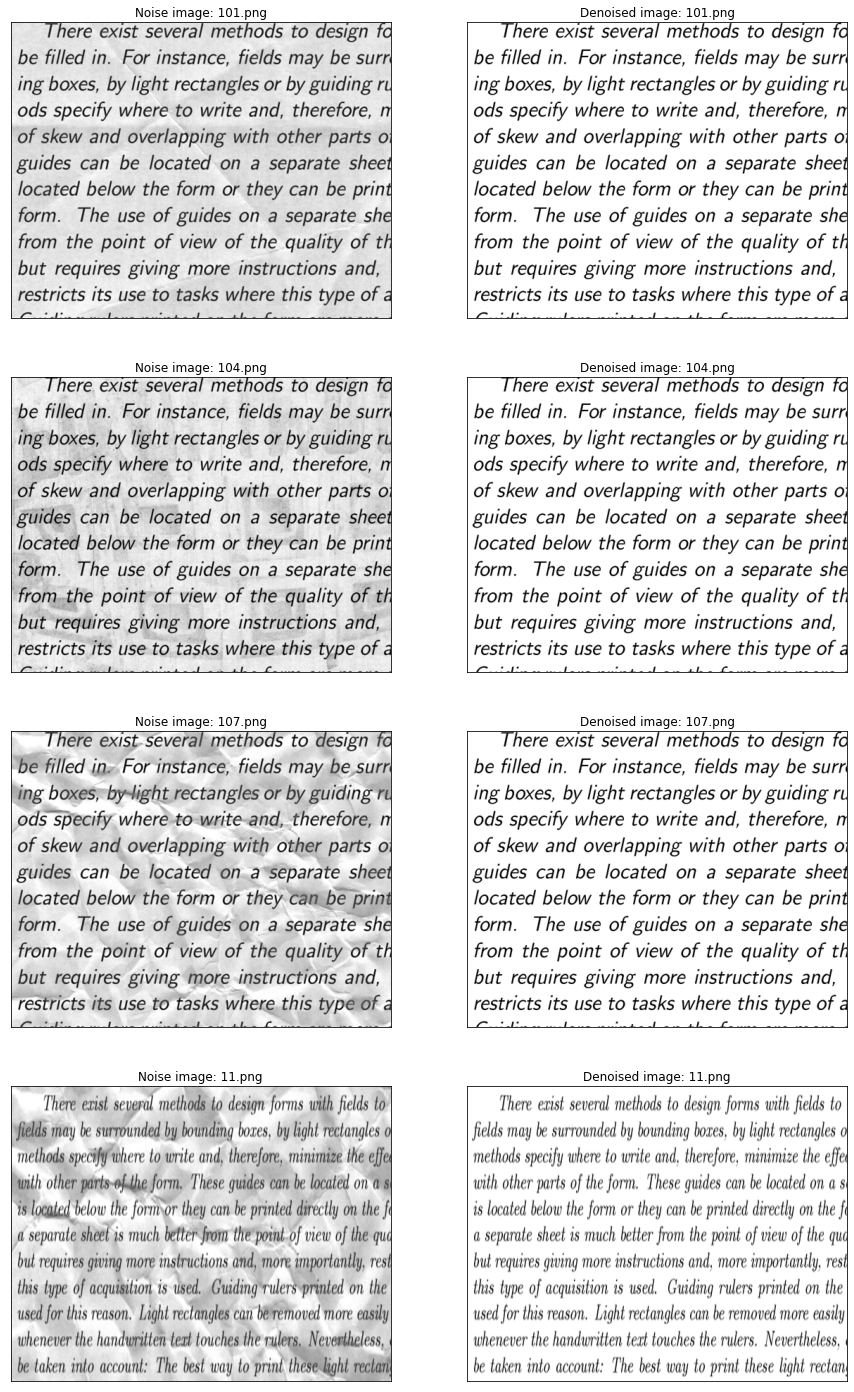

In [15]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [29]:
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

In [30]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [18]:
# input_layer = Input(shape=(None,None,1))

# # encoder
# e = Conv2D(32, (3, 3), padding='same')(input_layer)
# e = LeakyReLU(alpha=0.3)(e)
# e = BatchNormalization()(e)
# e = Conv2D(64, (3, 3), padding='same')(e)
# e = LeakyReLU(alpha=0.3)(e)
# e = BatchNormalization()(e)
# e = Conv2D(64, (3, 3), padding='same')(e)
# e = LeakyReLU(alpha=0.3)(e)
# e = MaxPooling2D((2, 2), padding='same')(e)

# # decoder
# d = Conv2D(64, (3, 3), padding='same')(e)
# d = LeakyReLU(alpha=0.3)(d)
# d = BatchNormalization()(d)

# d = Conv2D(64, (3, 3), padding='same')(d)
# d = LeakyReLU(alpha=0.3)(d)
# # e = BatchNormalization()(e)
# d = UpSampling2D((2, 2))(d)
# d = Conv2D(32, (3, 3), padding='same')(d)
# d = LeakyReLU(alpha=0.2)(d)
# # d = Conv2D(128, (3, 3), padding='same')(d)
# output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)

In [19]:
def model():
    input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model

In [20]:
model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

In [21]:
callback = EarlyStopping(monitor='loss', patience=10)

In [22]:
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=80, batch_size=12, verbose=1, callbacks=[callback])

Epoch 1/80
11/11 [==============================] - 35s 2s/step - loss: 0.1220 - mae: 0.2461 - val_loss: 0.2076 - val_mae: 0.4426
Epoch 2/80
11/11 [==============================] - 8s 696ms/step - loss: 0.0512 - mae: 0.1562 - val_loss: 0.1095 - val_mae: 0.3158
Epoch 3/80
11/11 [==============================] - 8s 699ms/step - loss: 0.0360 - mae: 0.1299 - val_loss: 0.0872 - val_mae: 0.2730
Epoch 4/80
11/11 [==============================] - 8s 704ms/step - loss: 0.0285 - mae: 0.1123 - val_loss: 0.0753 - val_mae: 0.2390
Epoch 5/80
11/11 [==============================] - 8s 711ms/step - loss: 0.0236 - mae: 0.0978 - val_loss: 0.0679 - val_mae: 0.2032
Epoch 6/80
11/11 [==============================] - 8s 716ms/step - loss: 0.0198 - mae: 0.0917 - val_loss: 0.0667 - val_mae: 0.1777
Epoch 7/80
11/11 [==============================] - 8s 723ms/step - loss: 0.0161 - mae: 0.0867 - val_loss: 0.0679 - val_mae: 0.1635
Epoch 8/80
11/11 [==============================] - 8s 727ms/step - loss: 0.01

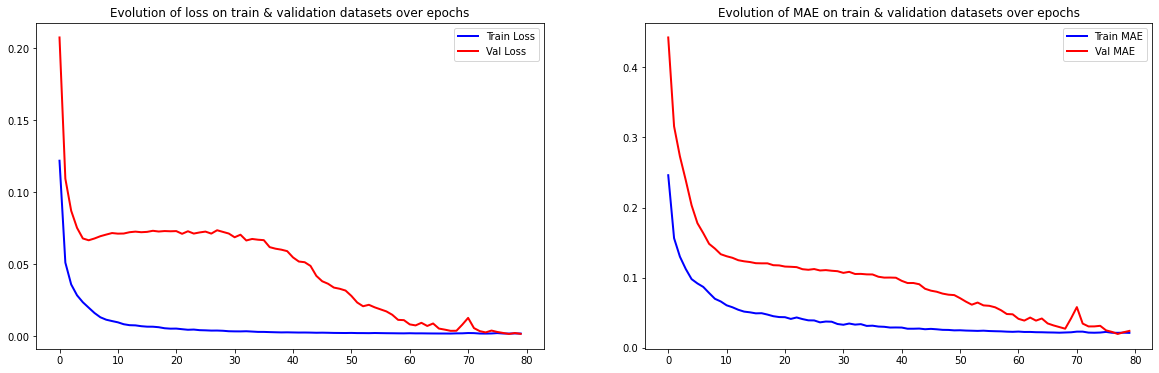

In [23]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [24]:
model.save_weights('/content/drive/MyDrive/Checkpoint_keras/auto_encoder_checkpoint')

In [33]:
Y_test = model.predict(X_test[-7:-1])

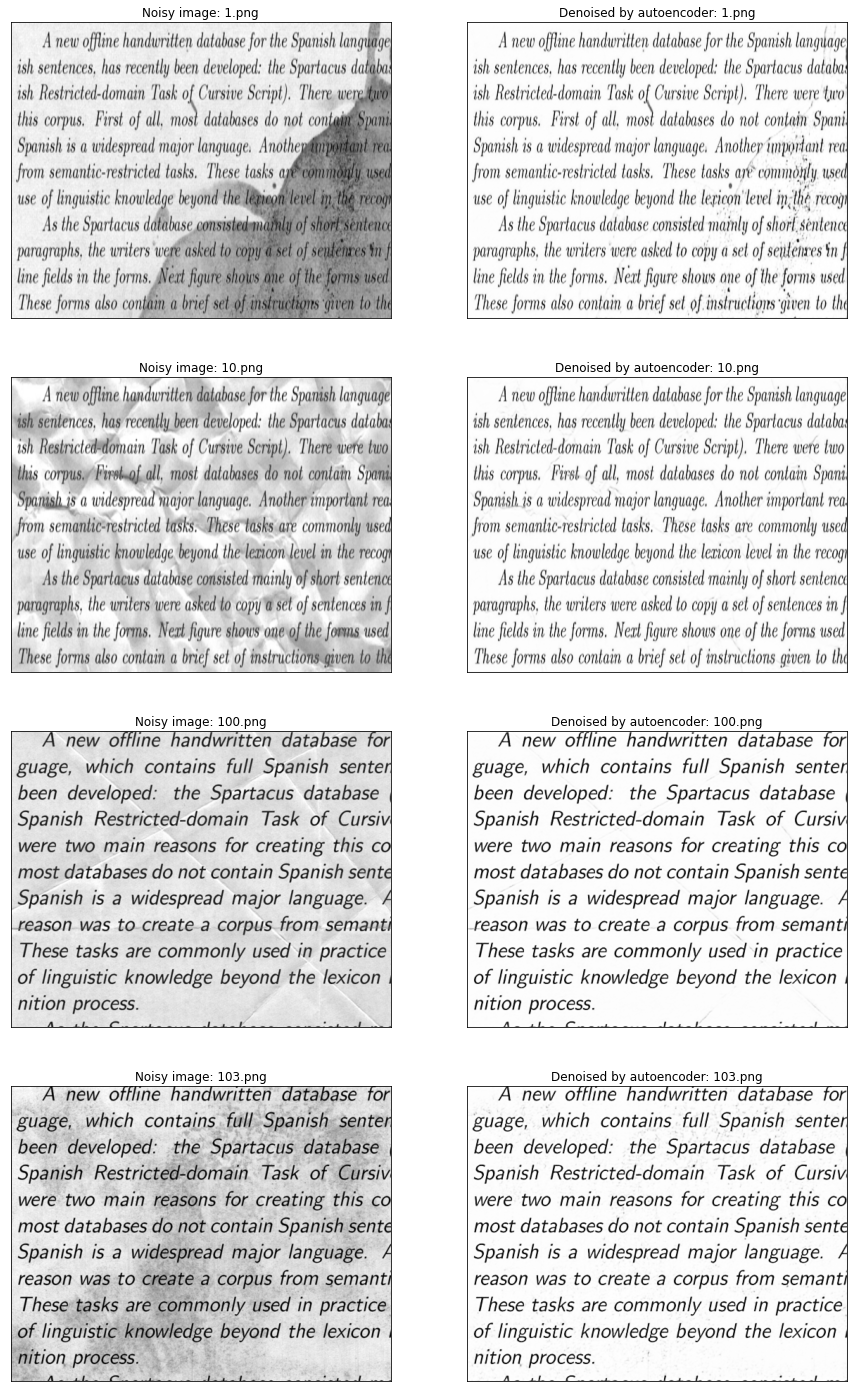

In [32]:
plt.figure(figsize=(15,25))

for i in range(0,8,2):
  index = int(i/2)
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_test[index][:,:,0], cmap='gray')
  plt.title('Noisy image: {}'.format(test_img[index]))
  
  plt.subplot(4,2,i+2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(Y_test[index][:,:,0], cmap='gray')
  plt.title('Denoised by autoencoder: {}'.format(test_img[index]))

plt.show()

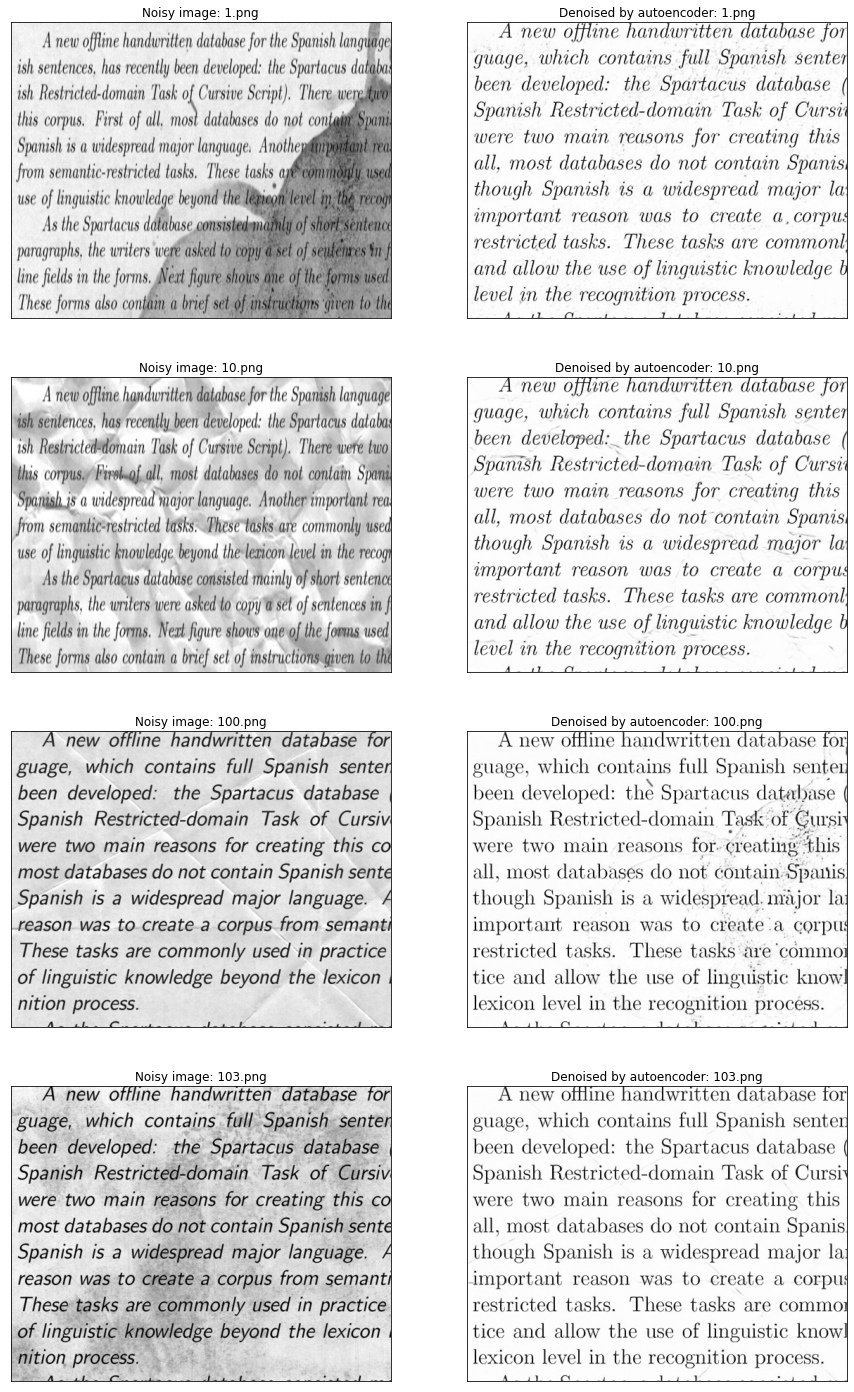

In [34]:
plt.figure(figsize=(15,25))

for i in range(0,8,2):
  index = int(i/2)
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_test[index][:,:,0], cmap='gray')
  plt.title('Noisy image: {}'.format(test_img[index]))
  
  plt.subplot(4,2,i+2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(Y_test[index][:,:,0], cmap='gray')
  plt.title('Denoised by autoencoder: {}'.format(test_img[index]))

plt.show()